# Neutral Review Classification

## Overview

Consumer reviews has historically been one of the best ways for business owners to understand more fully the needs and wants of their consumers, thus being an important tool for businesses to leverage in order to create a complete and enjoyable experience that encompasses their consuemr base. One important tool for this is business intelligence. However, business intelligence suites are generally expensive and inflexible, making it difficult for smaller businesses that are not largely scaled to gain a sufficient amount of value from these business suites to justify spending the amount it costs to utilize them. Thus, I wanted to create a business intelligence tool that could add value to consumer reviews that may not seem informationally valuable at first glance.

#### The Neutral Feedback Problem: 
Generally speaking, 4 and 5 star reviews are positive consumer experiences, and the language in these reviews reflect that with highlights and recommendations to others. On the other end of the spectrum, 1 and 2 star reviews are generally negative consumer experiences, and the language in these reviews are facets of the experience that consumers think should be improved. This can more easily be thought of as: 4-5 star reviews - highlights, and 1-2 star reviews - improvements needed. However, in the middle ground, a place of difficult interpretability, are the neutral 3 star reviews. These reviews typically have a middle ground between "highlights" and "improvements needed", thus making it difficult to quickly glean any information, unless a human manually goes through and classifies the language in the context of the review.

## Business Case

The goal of this project is to add informational value to the difficult-to-interpret reviews by classifying them as positive or negative, hopefully offering a quick way for small business owners to gain value from these neutral reviews.

## Start of Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import defaultdict
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score
import string
import pickle
import spacy
from nltk.util import ngrams
import nltk, re, string, collections

In [2]:
df = pd.read_csv('data/smaller/yelp_review.csv')
df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
df[df['stars'] == 3]

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
8,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3,2013-02-09,"Not bad!! Love that there is a gluten-free, vegan version of the cheese curds and gravy!!\n\nHaven't done the poutine taste test yet with smoke's but Im excited to see which is better. However poutini's might win as they are vegan and gluten-free",1,0,0
11,PdZ_uFjbbkjtm3SCY_KrZw,u0LXt3Uea_GidxRW1xcsfg,XWTPNfskXoUL-Lf32wSk0Q,3,2011-09-28,"Server was a little rude.\n\nOrdered the calamari, duck confit poutine and the trout fish with miso soba - all very tasty. Definitely not your typical diner.",5,0,1
13,lsoSqIrrDbQvWpMvsSj2xw,u0LXt3Uea_GidxRW1xcsfg,RtUvSWO_UZ8V3Wpj0n077w,3,2012-12-03,"Wanted to check out this place due to all the hype I had heard. My friend wanted to come here for her birthday. We had a group of seven and based on the way the seating works (as it is communal), we wind up sharing with another group of five. \n\nFood was ok - not sure what the hype was. Almost 75% of the dishes had some sort of cheese in it.\n\nThis place is very loud so not ideal for catching up\/talking. Not a great place to go if you have any gluten or vegan restrictions.\n\nInteresting concept. Would definitely recommend to try this place once - but definitely not worth the 30- 45 mins wait.",2,1,1
17,xdu8nXrbNKeaywCX79KZSw,u0LXt3Uea_GidxRW1xcsfg,PFPUMF38-lraKzLcTiz5gQ,3,2010-09-15,Came here with my girlfriends one Sunday afternoon. This place will take a long time to serve your food - as it took them almost an hour to give us our food. So make sure you give yourself lots of time! It is definitely a lazy brunch place!\n\nDefinitely recommend the pancakes! Beware of the portion sizes - they are huge!,2,0,0
18,K7o5jDInfmX3cY5oH6ATNw,u0LXt3Uea_GidxRW1xcsfg,oWTn2IzrprsRkPfULtjZtQ,3,2012-09-23,"Came here for a burger as one of my friends said they had good burgers and people from work would come by twice a month for a burger run.\n\nOrdered the original was was ok, wasn't as amazing as everyone says it to be. I think the veggie option would have been better.\n\nA little pricy for a take-out burger.",4,0,0
...,...,...,...,...,...,...,...,...,...
5261654,W63llfTEM02-WpKBA2P9pQ,mPjPyipaD0C_myqWqDipZg,KqtmbsZUDNNspTp1Yn2Mtw,3,2012-08-30,"They do deep tissue massage which most Chinese massage places provide but at a more attractive rate.\n\nComfort Zone Price:\n\n$38 for 45min\n\nMonday - Thursday before 7:00pm: $30.\n\nPlace is very clean and busy. Front desk girl is just interested in money (I guess), I feel like they over booked me and just opened a table in one of the room which had 3 chairs\/couch (for foot massage). Space was so tight the girl cannot even go around the table and had to push the table every time she wanted to come around (annoying noise).\n\nAt the end of the Massage, went back to front desk, handed over $40 and asked for $5 return and told the girl to give the masseuse the other $5. She said 'oh'...and put the $5 in the drawer and went on doing whatever she was doing.\n\nP.S. RMT receipt price: $70",5,2,0
5261655,C0uT2UJQ3yz9hqE4h3sy2A,mPjPyipaD0C_myqWqDipZg,n0NH0FW8NU3zfeJY3QluMQ,3,2015-10-25,"Went in for a snack on a sat night. Bar area was pretty pack, restaurant side was pretty dead. \n\nSat in the restaurant side. Service was non existent as the section was dead and the server would disappear after bringing the food. \n\nTypical bar food, nothing special.",1,0,0
5261664,-CJNPrDWgIkorx4iEZJXIg,mPjPyipaD0C_myqWqDipZg,pOEL97ld-FJMKO8Ki8JmYg,3,2016-04-30,"Spring rolls was pretty good, cod was a bit raw\/cold in the middle. Server was too cool..... As if he's doing us a favour.",0,0,0
5261666,hqQ1UTFKMN2P1ezUow48OQ,mPjPyipaD0C_myqWqDipZg,EO3i5kTUG7_S2OIQ23sdSA,3,2011-11-07,"A small, cozy family run Authentic korean restaurant. Chris Lee - the owner is very friendly and courteous. The price is generally about 25% more than other restaurants in the area.\n\nOrdered a whole bunch of fo

In [5]:
df.shape

(5261668, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261668 entries, 0 to 5261667
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_id    object
 1   user_id      object
 2   business_id  object
 3   stars        int64 
 4   date         object
 5   text         object
 6   useful       int64 
 7   funny        int64 
 8   cool         int64 
dtypes: int64(4), object(5)
memory usage: 361.3+ MB


In [7]:
df.isna().value_counts()

review_id  user_id  business_id  stars  date   text   useful  funny  cool 
False      False    False        False  False  False  False   False  False    5261668
dtype: int64

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261668 entries, 0 to 5261667
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   date         datetime64[ns]
 5   text         object        
 6   useful       int64         
 7   funny        int64         
 8   cool         int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 361.3+ MB


# Data Understanding

Some EDA and visualizations here to give us a better idea of the data we're working with

In [8]:
# Import list of stopwords from SpaCy
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [9]:
# Create a function to tokenize the text of the articles
punctuation = [*string.punctuation , *[str(x) for x in list(range(0,10))]]
nlp = spacy.load('en_core_web_sm')
def normalize(text):
    text = ''.join([x for x in text if x not in punctuation])
    toks = nlp(text)
    toks = [word.lemma_.lower().strip() for word in toks if word.pos_ != 'PRON']
    toks = [word for word in toks if word not in stop_words]
    return ' '.join(toks)

### Data Visualization

In [7]:
eda = df.sample(500000, random_state = 42)

In [8]:
eda.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
4528116,m5jjU8KhAPmDSa5BIopIqw,F9vYcUknd9JY2lxsaEObQQ,T6ihfy4SYiF4PvuE6Y0VPA,3,2015-01-29,"Airport Wendy's. You curbed my hunger. That was all I needed from you. The fries aren't tuuuurible, but I loaded them with salt and pepper and dipped away in ketchup. Wendy's you should probably have some tables, but I get it... you're in a tight place and I can just go eat at my gate. Which I did, but there were no tables at my gate so it became very awkward eating fries out of the bag off the ground while balancing a soda between my legs and holding a book in one hand and a burger in the other. Yes, I would like more tables, but this is an airport problem. Wendy's, you also reminded me that you've always been better than McDonald's and Burger King. You're okay in my book Wendy's.",1,2,2
3097267,pCURaqs8o9kCOl6fEVcsKA,H5d_nFqzwrREE-YduK2ABg,fPpO5751xJI78__uTU2q7g,5,2008-01-13,"I stumbled across this store on my way to Nest. They are right next door to each other. I love, love, love the furniture here. It is very expensive, very high quality and very traditional. The store is small, but it jammed packed full of furniture and fine accessories. I have been looking for a classic design floor lamp and they had some real impressive designs. I also liked several of their wall mirrors as well as buffet lamps. Nice artwork. They also employee professional designers to guide you in designing your perfect new room.",19,6,13
2290314,2C8Gr_EX_gVTlJsobcey6w,xycmBfvZtDX9Bao9kwNQCw,sdE4iWulUozJXOxzQ5Bjhw,3,2016-05-22,"Pizza was decent. Very disappointed in the delivery. I was told it would be at my house in 45 minutes, but it came in less than 30 which I was not prepared for and caught me off guard. I'm very mad and furious at the horrible customer service, but the pizza was good tho",0,3,0
1146971,JWwPv1cIS0YfiQrKtcL9nA,dccateTjyakPfsWd5U0wsQ,K6fYrrTorlpXmqutRcrHzg,3,2010-01-15,"My first time: the bartenders were so cute [and happy!] ! \nSecond time, my bartender seemed a bit jaded, quiet, and impatient [although knowledgeable] because I was very indecisive for my beer selection. They had a very large selection, at least 10 drafts and 20 bottles, of all styles, mostly American microbrews, and at least 5 of the large bottled ones that are $10 or so each. For the beer you're getting, the prices are reasonable. \n\nThe walls are brick and there's 4 or 5 small TVs placed for almost every seat to have a decent view. \n\nThe beer selection is better than some other places in Tremont but both times [wintery weekday nights], the place was dead. \n\nI'll be back eventually, though probably not until it's springtime and the patio is open for happy hour.",3,1,1
3184541,xW3umQlqu00xiu9UgkBDHw,OvpTIjhGpg2y2kklHa47NQ,Jt28TYWanzKrJYYr0Tf1MQ,3,2014-12-11,"I was in las vegas staying at the Paris hotel for my sisters bachelorette weekend and we decided to come here for breakfast before walking the whole strip. I thought it was way too early to drink so I didnt get to taste the drinks but the girls said they were strong and good. I don't recall the name of what I had for breakfast but do remember finishing the whole plate and it was just what i needed. In fact, all the girls devoured most of their food. We were at the outdoors seating and it was nice for people watching, and to plan our next adventure. I would return here on MY future bachelorette weekend !!",0,0,2


#### Word Cloud

In [9]:
# Apply tokenization function to the real articles. Create a new column for the processed articles
eda['processed_articles'] = eda['text'].map(lambda x: normalize(x))

In [10]:
true_text = eda.processed_articles

In [5]:
filename = 'pickle/true_text'
pickle.dump(true_text, open(filename, 'wb'))

NameError: name 'true_text' is not defined

In [6]:
true_text = pickle.load(open('pickle/true_text', 'rb'))

In [7]:
# Create a list of all of the tokenized words
true_list = []
for x in true_text:
    true_list.append(x)

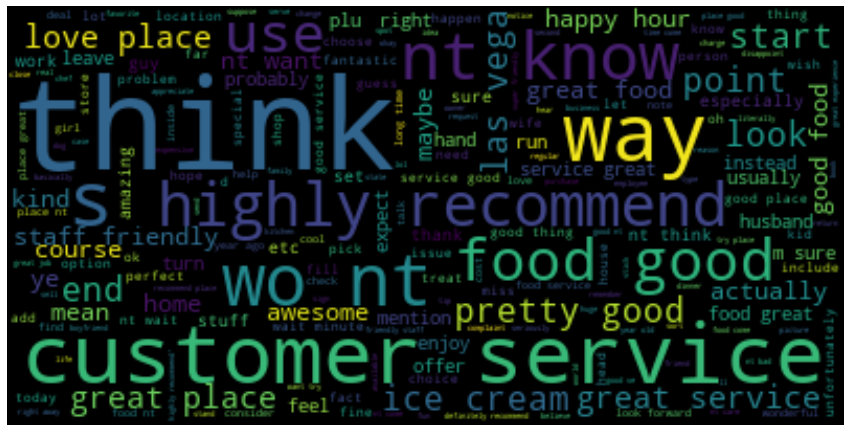

In [18]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(true_list))

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('images/wordcloud.png')
plt.show()

#### Frequency Distribution

In [9]:
# Create a new list of stopwords
stopwords = ['m', 've', 'nt', '``', 's', 'c', "'", ",", "t", "l", 'j', '...', ":", '0', '1', '2', 'couldn', 'wouldn', 'isn', 'aren', 'shouldn', 'don', 'doesn', 'didn']
# Create a new tokenized list to use in the frequency distribution tables
true_tokenized_word = nltk.word_tokenize(str(true_list))

In [10]:
# Iterate through new tokenized list and remove additional stopwords.
true_tokenized_word = [word for word in true_tokenized_word if word not in stopwords]

In [11]:
# Create frequency distribution for the words in the real articles
true_fdist=nltk.FreqDist(true_tokenized_word)

In [12]:
print(true_fdist.most_common(20))

[('good', 312197), ('place', 262449), ('food', 246435), ('time', 207840), ('great', 198186), ('like', 191878), ('service', 183257), ('come', 180968), ('order', 164091), ('try', 124645), ('look', 96815), ('nice', 93070), ('want', 92074), ('price', 89806), ('restaurant', 89458), ('love', 88803), ('wait', 85336), ('know', 81277), ('eat', 80348), ('staff', 78057)]


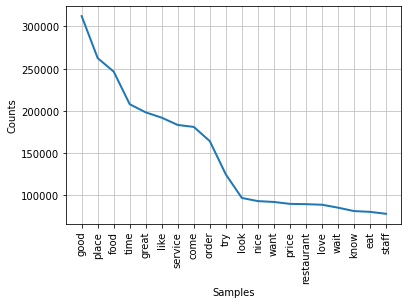

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot frequency distribution for the 20 most common words
true_fdist.plot(20)
plt.savefig('images/freq_dist.png')
plt.show()

#### Bigrams

In [14]:
# Get a list of all the bi-grams
true_bigrams = ngrams(true_tokenized_word, 2)

In [15]:
# List 20 most common bigrams
true_bigrams_freq = collections.Counter(true_bigrams)
true_bigrams_freq.most_common(20)

[(('customer', 'service'), 25051),
 (('highly', 'recommend'), 20571),
 (('feel', 'like'), 17712),
 (('food', 'good'), 14539),
 (('pretty', 'good'), 13075),
 (('ice', 'cream'), 12746),
 (('las', 'vegas'), 12738),
 (('look', 'like'), 12386),
 (('staff', 'friendly'), 11246),
 (('great', 'service'), 10428),
 (('service', 'great'), 10327),
 (('happy', 'hour'), 10208),
 (('taste', 'like'), 10026),
 (('food', 'great'), 9447),
 (('good', 'food'), 9189),
 (('great', 'place'), 8815),
 (('service', 'good'), 8599),
 (('good', 'service'), 8012),
 (('great', 'food'), 8003),
 (('recommend', 'place'), 7385)]

In [16]:
true_bigram_fdist=nltk.FreqDist(true_bigrams_freq)

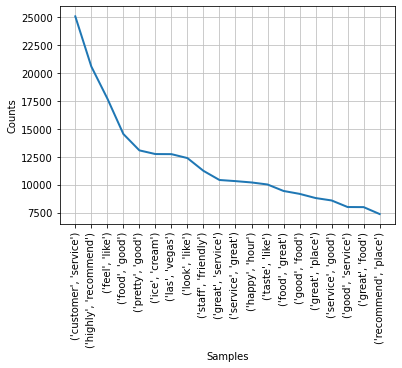

<Figure size 432x288 with 0 Axes>

In [26]:
true_bigram_fdist.plot(20)
plt.savefig('images/bigram_freq.png')
plt.show()

#### Star Distribution

In [12]:
list(eda['stars'].value_counts().values)

[2253347, 1223316, 731363, 615481, 438161]

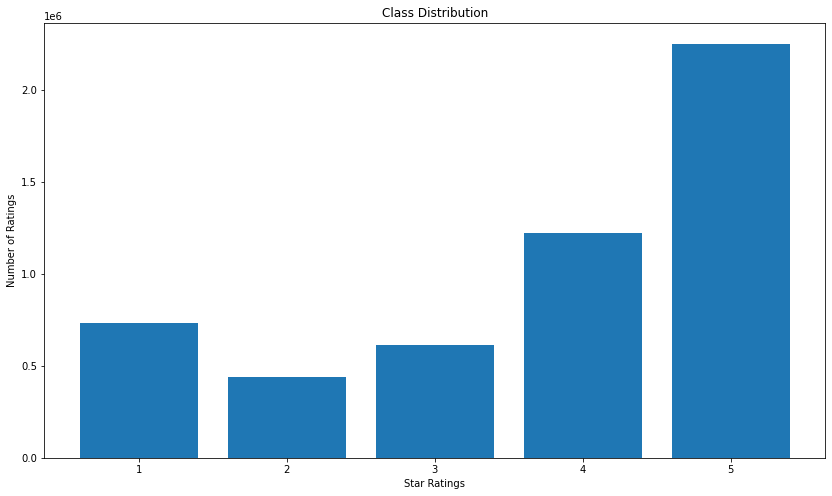

In [13]:
# ratings distribution
fig, ax = plt.subplots(figsize = (14,8))
plt.bar(eda["stars"].value_counts().keys(), eda['stars'].value_counts().values)
ax.set_xlabel('Star Ratings')
ax.set_ylabel('Number of Ratings')
ax.set_title('Class Distribution')

plt.savefig('images/stars_distribution.png')

# Modeling Preparation

## Drop Neutral Reviews

Because neutral reviews aren't classified as positive or negative at this point, we can't train the model on them. We will drop the 3 star reviews for now, then manually classify them in a different dataset, at which point we will add them back into this training set with a holdout for validation

In [14]:
df.drop(df[df['stars'] == 3].index, inplace = True)

In [15]:
df['stars'].value_counts()

5    2253347
4    1223316
1     731363
2     438161
Name: stars, dtype: int64

## Adding in Manually Classified Dataset

As stated above, this dataset is the 3 star reviews that were removed for the sake of training. This section adds them back in

In [16]:
manual_classified = pd.read_csv('data/manual_classified.csv')

In [17]:
manual_classified.shape

(209, 11)

In [18]:
# adding the training portion of the manually classified dataset
manual_training = manual_classified.sample(150, random_state = 42)

In [19]:
manual_training.shape

(150, 11)

In [20]:
# setting the testing set of the manual classified dataset
manual_test = manual_classified[~manual_classified.index.isin(manual_training.index)]

In [21]:
manual_test.shape

(59, 11)

## Setting Target Variable

In [22]:
df['target'] = df['stars'] > 3

In [13]:
df.tail()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,target
5261660,dyW1tIaWbm_RfCFCffY9yg,mPjPyipaD0C_myqWqDipZg,Dv0OHpQSL4hOGl2KAEVvlA,2,2012-05-05,"Not much to write about, food is mediocre at best. Atmosphere was bar style.\n\nAsked the server if they had 'Aged beef steak' she said 'they do not have HP steak, but she can bring the sauce on the side'",0,1,0,False
5261661,ZU2UF0YBkhQFctXH5Mry3A,mPjPyipaD0C_myqWqDipZg,CMkayuNDHPcd1dxO32kJyA,1,2012-05-24,"This place is retarded!!! Called on a thursday, confirmed that the price of the buffet today dinner is $8.99, Weekend is $10.99. Headed out...\n\nWhen we arrived, there was couple of dudes sitting at the bar and told us, they are closed today and is only open on Fri\/Sat\/Sun. WTF....???\n\nSunday comes around, thought we'd give this place another try. Headed out... Arrived, the doors were locked and nobody was inside...WTF???",4,4,1,False
5261662,evfB2Xzw4u7aYftWClQfeg,mPjPyipaD0C_myqWqDipZg,--SrzpvFLwP_YFwB_Cetow,2,2011-10-18,"So after reading Precilla C. review, I decided to try this location. I've been to their Hwy 7 \/ Kennedy location few times and the food was 'OK'.\n\nOnce I got to the restaurant I totally forgot what to order...lol. Ended up getting:\n\n1) Big bowl soup\n2) Noodles with spicy shredded pork\n3) Spicy Chilly steamed fish\n\nI just made those names up...but they all have pictures.\n\n1) Soup is the same as the other location, nothing to brag about, just very fresh and delicious.\n\n2) Even though it was suppose to be spicy pork, it tasted sweet. not spicy AT ALL. it comes with a bowl of msg hot water (i think they call it soup). Which the waiter spilled over the table and one of the chair.\n\n3) Fish itself was good, but they used the flavorless chilies, no taste.\n\nSERVICE:\n\nThis place have one of the WORST service. Went at 8:00pm on a wednesday, restataurant was 60% empty and they had 3 waiters that have a very unique skill of walking around without looking at you. Sort of like AYCE Japanese restaurant. Had to wait 15~20min before we could flag down a retarded fat ass lazy waiter.\n\nSince i don't speak cantonese, i was ordering in english and he would yell out loud the dish i wanted in Cantonese....in a signing tone...WTF???\n\nWhen he brought over the #2) dish, he spilled half of it on his hand, table and chair beside me...no big deal. BUT ATLEAST CLEAN IT UP!!!. When he brought over the #1) and #3) i asked him each time to clean that up, he just rolled his eyes. I finally had to flag down ANOTHER WAITER (which was a challenge itself) to clean it up. \n\nAnyways, bill came up to $30ish+, left him $0.01 tips.\n\nP.S. The staff in Kennedy\/Hwy 7 is MUCH friendlier",0,0,0,False
5261663,PoGSiNz1X5SUu0qEt-qM5w,mPjPyipaD0C_myqWqDipZg,Ngk84Ax1tXgpoJFEGxot3w,1,2011-11-21,"Bought groupon $39 for 4 months from groupon, the sign up guy tried so hard to sell a 'new' package to me. I asked him if I can make up my mind after I tried the gym out first, but he insisted I do it now or else the price will go up. As a matter of fact, he has a price increase meeting tomorrow....hahaha\n\nDid not opt for the 'new' package, stuck with my original package. He seemed upset...said fine, your membership expires in 4 months, you just get your membership and nothing else, you will have to pay for parking too. I told him...but I see that there is a sign that says one hr free parking. umm...err...ehhh...yeah, well, only one hr free, after that you will have to pay $3\/hr. whatever...\n\nAfter signing everything, he said you will get your access card after you finish your assessment (aka personal trainer sales pitch). I told him I do not need an assessment as I will only be using the treadmill. He said I HAVE to get an assessment for insurance purpose....LAAAME!\n\nwill update after my physical assessment.",36,3,3,False
5261665,W9eVvOcpBvG6lpJPoJOxuA,mPjPyipaD0C_myqWqDipZg,5ubokMNw8qfbX2WtxgJG1Q,4,2011-10-23,"Had a 8 dish set meal, was enough for 10 people for $126

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4646187 entries, 0 to 5261665
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   date         datetime64[ns]
 5   text         object        
 6   useful       int64         
 7   funny        int64         
 8   cool         int64         
 9   target       bool          
dtypes: bool(1), datetime64[ns](1), int64(4), object(4)
memory usage: 358.9+ MB


In [21]:
df['stars'].value_counts()

5    2253347
4    1223316
1     731363
2     438161
Name: stars, dtype: int64

# Start of NLP

In [23]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score
import string
import pickle

In [24]:
# because of computational power, we limit the training and testing sample to 500,000 entries
sample = df.sample(500000, random_state = 42)

In [25]:
# to ensure that we have the neutral reviews in here, we append them manually
sample = sample.append(manual_training)

In [26]:
sample['stars'].value_counts()

5    242542
4    131894
1     78470
2     47094
3       150
Name: stars, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split

X = sample['text']
y = sample['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### Count Vectorizer (not used in final results)

In [20]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_train)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_train.index, inplace=True)

In [21]:
X_val_vec = cv.transform(X_test)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
# X_val_vec.set_index(y_train.index, inplace=True)

In [22]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_train)
y_hat = mnb.predict(X_val_vec)
y_hat

array([ True, False,  True, ...,  True, False,  True])

## TF IDF Vectorization

In [27]:
# stopwords

import nltk
nltk.download('stopwords')

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', '-', "'"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nehcr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# function for removing stopwords

nltk.download('punkt')

def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nehcr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
# mapping funtion to X_train and X_test

processed_X_t = list(map(process_article, X_train))

processed_X_val = list(map(process_article, X_test))

KeyboardInterrupt: 

In [ ]:
processed_X_t

In [23]:
# RegEx 
## to get everything between square brackets: r'[[].*?[]]'
## to get everything that starts with a capital letter: r'[[][A-Z].*?[]]''
## to get everything that starts with a capital letter and no white space: r'[[][A-Z][a-z]*?[]]'

regex_person_reg = r"([A-Z][a-z].*?[^\s]*)\:"
regex_person_upper = r"([A-Z][^\s]*)\:"
regex_parens = r'[[][A-Z].*?[]]'


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tf_idf_data_train = vectorizer.fit_transform(X_train, y_train)
tf_idf_data_test = vectorizer.transform(X_test)

In [29]:
# pickle vectorizer

filename = 'pickle/tfidf_vectorizer'
pickle.dump(vectorizer, open(filename, 'wb'))

In [30]:
# load vectorizer

nb_train_preds = pickle.load(open('pickle/tfidf_vectorizer', 'rb'))

# Start of Modeling

## Baseline Modeling - NB and RF

In [36]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [37]:
nb_classifier.fit(tf_idf_data_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [38]:
rf_classifier.fit(tf_idf_data_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

#### Pickle Predictions - NB

In [39]:
import pickle

# pickle Naive Bayes Classifier

filename = 'pickle/nb_classifier'
pickle.dump(nb_classifier, open(filename, 'wb'))

In [40]:
# pickle Naive Bayes Classifier train predictions

filename = 'pickle/nb_train_preds'
pickle.dump(nb_train_preds, open(filename, 'wb'))

In [41]:
# pickle Naive Bayes Classifier test predictions

filename = 'pickle/nb_test_preds'
pickle.dump(nb_test_preds, open(filename, 'wb'))

#### Pickle Preds - RF

In [42]:
# pickle Random Forest Classifier

filename = 'pickle/rf_classifier'
pickle.dump(rf_classifier, open(filename, 'wb'))

In [43]:
# pickle Random Forest Classifier train predictions

filename = 'pickle/rf_train_preds'
pickle.dump(rf_train_preds, open(filename, 'wb'))

In [44]:
# pickle Random Forest Classifier test predictions

filename = 'pickle/rf_test_preds'
pickle.dump(rf_test_preds, open(filename, 'wb'))

#### Load Preds

In [10]:
# load nb train preds

nb_train_preds = pickle.load(open('pickle/nb_train_preds', 'rb'))

In [11]:
# load nb test preds

nb_test_preds = pickle.load(open('pickle/nb_test_preds', 'rb'))

In [12]:
# load rf train preds

rf_train_preds = pickle.load(open('pickle/rf_train_preds', 'rb'))

In [13]:
# load nb test preds

rf_test_preds = pickle.load(open('pickle/rf_test_preds', 'rb'))

### Prediction Metrics

In [45]:
nb_train_score = f1_score(y_train, nb_train_preds)
nb_test_score = f1_score(y_test, nb_test_preds)
rf_train_score = f1_score(y_train, rf_train_preds)
rf_test_score = f1_score(y_test, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training F1: {:.4} \t\t".format(nb_train_score))
print("")
print("Test F1: {:.4} \t\t".format(nb_test_score))
print('-'*70)
print("")
print('Random Forest')
print("Training F1: {:.4} \t\t".format(rf_train_score))
print("")
print("Test F1: {:.4} \t\t".format(nb_test_score))

Multinomial Naive Bayes
Training F1: 0.926 		

Test F1: 0.922 		
----------------------------------------------------------------------

Random Forest
Training F1: 1.0 		

Test F1: 0.922 		


### NB and RF Modeling Review
Based on what we see here, these models both seem pretty good! A relatively steep drop off from the training score and the testing score is somwhat concerning on the Random Forest model, though. Could be overfit.

One thing about the metric we're using, F1: I thought that the F1 score would be pretty relevant because we aren't too concerned about false positives and false negatives, like we would be if we were predicting the chance of a disease or something like that. We do have somewhat of a class imbalance as well, with much more of the positive reviews than the negative reviews. Thus, F1 score is a decent metric to use.

### Baseline Logistic Regression Model

In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 500)
lr.fit(tf_idf_data_train, y_train)
lr_train_preds = lr.predict(tf_idf_data_train)
lr_test_preds = lr.predict(tf_idf_data_test)

In [53]:
# Pickle lr model and predictions

filename = 'pickle/lr_classifier'
pickle.dump(lr, open(filename, 'wb'))

filename = 'pickle/lr_train_preds'
pickle.dump(lr_train_preds, open(filename, 'wb'))

filename = 'pickle/lr_test_preds'
pickle.dump(lr_test_preds, open(filename, 'wb'))

#### Load LR Pickle

In [16]:
# load lr pickle

lr_train_preds = pickle.load(open('pickle/lr_train_preds', 'rb'))

lr_test_preds = pickle.load(open('pickle/lr_test_preds', 'rb'))

In [15]:
lr_train_score = f1_score(y_train, lr_train_preds)
lr_test_score = f1_score(y_test, lr_test_preds)

print("Logistic Regression")
print("Training F1: {:.4} \t\t".format(lr_train_score))
print("Test F1: {:.4} \t\t".format(lr_test_score))

NameError: name 'y_train' is not defined

### Logistic Regression Model Review
Great scores on both training and especially testing. I will move forward from here by using Logistic Regression.

## Grid Search

In [56]:
params = {'solver': ['newton-cg'],
          'penalty': ['l2', 'elasticnet'], 
          'tol': [0.5, 1.0, 2.0],
          'C': [1.0, 2.0, 3.0]}

In [33]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LogisticRegression(), param_grid = params)
grid.fit(tf_idf_data_train, y_train)

C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1.0, 2.0, 3.0], 'penalty': ['l2', 'elasticnet'],
                         'solver': ['newton-cg'], 'tol': [0.5, 1.0, 2.0]})

In [34]:
grid.cv_results_

{'mean_fit_time': array([17.56059937, 15.68087935, 14.38120084,  0.13113747,  0.12459917,
         0.12379971, 17.91945944, 16.60968328, 14.14945025,  0.12900357,
         0.12380009,  0.12539043, 17.92844367, 16.84685178, 16.09444642,
         0.13163686,  0.12380939,  0.12532287]),
 'std_fit_time': array([6.31652949e-01, 7.95785562e-01, 1.13333698e+00, 7.69879625e-03,
        4.89470019e-04, 3.98961008e-04, 9.24144856e-01, 6.85312223e-01,
        3.26180676e-02, 7.56189488e-03, 3.99139801e-04, 1.61900036e-03,
        9.72608963e-02, 8.47213536e-01, 8.90567035e-02, 8.16743808e-03,
        6.50141794e-04, 2.37414189e-03]),
 'mean_score_time': array([0.0300127 , 0.02719059, 0.02638774, 0.        , 0.        ,
        0.        , 0.02600636, 0.02598028, 0.02579803, 0.        ,
        0.        , 0.        , 0.02640448, 0.02619963, 0.02660608,
        0.        , 0.        , 0.        ]),
 'std_score_time': array([0.00156128, 0.00117182, 0.00048056, 0.        , 0.        ,
        0.    

In [72]:
from sklearn.linear_model import LogisticRegression

lr_tuned = LogisticRegression(max_iter = 500, C = 3, penalty = 'l2', solver = 'newton-cg', tol = 1)
lr_tuned.fit(tf_idf_data_train, y_train)
lr_tuned_train_preds = lr_tuned.predict(tf_idf_data_train)
lr_tuned_test_preds = lr_tuned.predict(tf_idf_data_test)

In [58]:
# Pickle tuned lr model and predictions

filename = 'pickle/lr_classifier_tuned'
pickle.dump(lr_tuned, open(filename, 'wb'))

filename = 'pickle/lr_tuned_train_preds'
pickle.dump(lr_tuned_train_preds, open(filename, 'wb'))

filename = 'pickle/lr_tuned_test_preds'
pickle.dump(lr_tuned_test_preds, open(filename, 'wb'))

In [17]:
# Load tuned lr pickle

# load lr pickle

lr_tuned_train_preds = pickle.load(open('pickle/lr_tuned_train_preds', 'rb'))

lr_tuned_test_preds = pickle.load(open('pickle/lr_tuned_test_preds', 'rb'))

### Tuned Logistic Regression Results

In [60]:
lr_train_score = f1_score(y_train, lr_tuned_train_preds)
lr_test_score = f1_score(y_test, lr_tuned_test_preds)

print("Logistic Regression")
print("Training F1: {:.4} \t\t".format(lr_train_score))
print("Test F1: {:.4} \t\t".format(lr_test_score))

Logistic Regression
Training F1: 0.978 		
Test F1: 0.9706 		


As we can see, slightly better results here after tuning the model. I ran through this grid search multiple times with different parameters (although it is not shown since I went back into the original parameter cell and altered it based on previous grid search results). I think this is a good enough tuned model to move forward with and test our neutral reviews on. 

## Predicting on Manually Classified Neutrals
Some deviations here from the presentation metrics because I added in more entries to the testing set

In [61]:
X_val = manual_test['text']
y_val = manual_test['target']

In [62]:
tf_idf_data_val = vectorizer.transform(X_val)

Baseline LR model

In [18]:
# baseline lr validation
lr = pickle.load(open('pickle/lr_classifier', 'rb'))

In [70]:
lr_val_preds = lr.predict(tf_idf_data_val)

In [71]:
lr_val_score = f1_score(y_val, lr_val_preds)

print("Val F1: {:.4} \t\t".format(lr_val_score))

Val F1: 0.7342 		


Tuned LR model

In [19]:
# tuned lr validation
lr_tuned = pickle.load(open('pickle/lr_classifier_tuned', 'rb'))

In [73]:
lr_tuned_val_preds = lr_tuned.predict(tf_idf_data_val)

In [74]:
lr_tuned_val_score = f1_score(y_val, lr_tuned_val_preds)

print("Val F1: {:.4} \t\t".format(lr_val_score))

Val F1: 0.7342 		


Basically no difference between the original baseline Logistic Regression model and the tuned Logistic Regression model. Either way, the models are predicting correctly around 73% of the time. A large portion of this is probably because of how few entries we have in the Neutral Reviews validation dataset, so the tuning isn't being fully put to use here. However, we cannot say that with absolute certainty. 

# Conclusions

In conclusion to all of this, we can see that generally speaking, Logistic Regression works the best for NLP. Of course, more neutral review data is needed for both training and validation, as adding just ~10 more entries to the validation data increased the F1 score by 5-6%. Also, the ability to separate between domains (restaurants, services, hotels, etc.) will give a huge boost to the usability of the model. 

##### Conclusion F1 Scores
>
> <b>Baseline Logistic Regression:</b>
>
> Training F1: 0.9739
>
> Test F1: 0.9697

> <b>Tuned Logistic Regression:</b>
>
> Training F1: 0.978 		
>
> Test F1: 0.9706 

> <b>Neutral Review Validation (Neutral Reviews Only):</b>
>
> Val F1: 0.7342

As of now, we have a model in which we can enter a text review, and retrieve a prediction as to whether that text review is positive or negative. However, there is not a complete business use for this until we can retrieve the predicted positive or negative as well as tokenized words to make it faster to gain insights from, which was the point of the project. Thus, I am working on deploying a webapp through Streamlit in which a user can enter the text of a reviews, and retrieve both the predicted positive or negative rating, and the tokenized words in the review, making for a quick way to gain insights. 

Below, I have an example of a Webapp I am in the progress of making. Hopefully, it can be finished and deployed soon. 

## Streamlit Webapp (In Progress)

In [20]:
!pip install streamlit scikit-learn joblib

You should consider upgrading via the 'c:\users\nehcr\anaconda3\envs\learn-env\python.exe -m pip install --upgrade pip' command.


In [21]:
pip install --upgrade protobuf

  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\nehcr\\AppData\\Local\\Temp\\pip-uninstall-7cs6zxcj\\internal\\_api_implementation.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Users\nehcr\anaconda3\envs\learn-env\python.exe -m pip install --upgrade pip' command.


In [22]:
import streamlit as st 
import joblib,os
import spacy
import pandas as pd
nlp = spacy.load('en_core_web_sm')
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.use("Agg")
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def main():
    '''Review Classifier App with Streamlit'''
    st.title('Neutral Review Classifier ML App')
    st.subheader('NLP and ML App with Streamlit')
    
    activities = ['Prediction', 'NLP']
    
    choice = st.sidebar.selectbox('Choose Activity', activities)
    
    if choice == 'Prediction':
        st.info('Prediction with ML')
        
        review_text = st.text_area('Enter Text', 'Type Here')
        all_ml_models = ['Logistic Regression']
        model_choice = st.selectbox('Choose ML Model', all_ml_models)
        prediction_labels = {'Negative': 0, 'Positive': 1}
        if st.button('Classify'):
            st.text('Original Test ::\n{}'.format(review_text))
        
        # 14:17 video timestamp
        
        
    if choice == 'NLP':
        st.info('Natural Language Processing')
    
    
if __name__ == '__main__':
    main()

In [ ]:
import streamlit as st 
import joblib,os
import spacy
import pandas as pd
nlp = spacy.load('en_core_web_sm')
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.use("Agg")
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# load Vectorizer For Gender Prediction
news_vectorizer = open("pickle/tfidf_vectorizer","rb")
news_cv = joblib.load(news_vectorizer)

def load_prediction_models(model_file):
	loaded_model = joblib.load(open(os.path.join(model_file),"rb"))
	return loaded_model

# Get the Keys
def get_key(val,my_dict):
	for key,value in my_dict.items():
		if val == value:
			return key

def main():
	"""Review Classifier"""
	st.title("Review Classifier")
	# st.subheader("ML App with Streamlit")
	html_temp = """
	<div style="background-color:blue;padding:10px">
	<h1 style="color:white;text-align:center;">Streamlit ML App </h1>
	</div>
	"""
	st.markdown(html_temp,unsafe_allow_html=True)

	activity = ['Prediction','NLP']
	choice = st.sidebar.selectbox("Select Activity",activity)


	if choice == 'Prediction':
		st.info("Prediction with ML")

		news_text = st.text_area("Enter News Here","Type Here")
		all_ml_models = ["LR","NB"]
		model_choice = st.selectbox("Select Model",all_ml_models)

		prediction_labels = {'negative': 0,'positive': 1}
		if st.button("Classify"):
			st.text("Original Text::\n{}".format(news_text))
			vect_text = news_cv.transform([news_text]).toarray()
			if model_choice == 'LR':
				predictor = load_prediction_models("pickle/lr_classifier_tuned")
				prediction = predictor.predict(vect_text)
				# st.write(prediction)
			elif model_choice == 'NB':
				predictor = load_prediction_models("pickle/nb_classifier")
				prediction = predictor.predict(vect_text)
				# st.write(prediction)
			final_result = get_key(prediction,prediction_labels)
			st.success("Reviewgorized as:: {}".format(final_result))

	if choice == 'NLP':
		st.info("Natural Language Processing of Text")
		raw_text = st.text_area("Enter News Here","Type Here")
		nlp_task = ["Tokenization","Lemmatization","NER","POS Tags"]
		task_choice = st.selectbox("Choose NLP Task",nlp_task)
		if st.button("Analyze"):
			st.info("Original Text::\n{}".format(raw_text))

			docx = nlp(raw_text)
			if task_choice == 'Tokenization':
				result = [token.text for token in docx ]
			elif task_choice == 'Lemmatization':
				result = ["'Token':{},'Lemma':{}".format(token.text,token.lemma_) for token in docx]
			elif task_choice == 'NER':
				result = [(entity.text,entity.label_)for entity in docx.ents]
			elif task_choice == 'POS Tags':
				result = ["'Token':{},'POS':{},'Dependency':{}".format(word.text,word.tag_,word.dep_) for word in docx]

			st.json(result)

		if st.button("Tabulize"):
			docx = nlp(raw_text)
			c_tokens = [token.text for token in docx ]
			c_lemma = [token.lemma_ for token in docx ]
			c_pos = [token.pos_ for token in docx ]

			new_df = pd.DataFrame(zip(c_tokens,c_lemma,c_pos),columns=['Tokens','Lemma','POS'])
			st.dataframe(new_df)


		if st.checkbox("WordCloud"):
			c_text = raw_text
			wordcloud = WordCloud().generate(c_text)
			plt.imshow(wordcloud,interpolation='bilinear')
			plt.axis("off")
			st.pyplot()









	st.sidebar.subheader("About")

In [ ]:
# https://www.youtube.com/watch?v=bEOiYF1a6Ak